
# AdraDaline — Preview‑first Shapes **+ SVG Import** (~8 km), City Hall Start/Finish — 2 km radius

**Workflow**
1) **미리보기(Preview)** 셀에서 모양을 먼저 확인합니다.  
2) 마음에 들면 **`PROCEED = True`로 바꾸고**, 위에서부터 다시 실행하면 실제 경로가 생성됩니다.

**지원 모드**
- Built‑in shapes: star / heart / triangle / polygon / spiral / arrow / dog  
- **SVG 템플릿**: 임의의 .svg 경로를 지정해 외곽선을 Centerline으로 사용


## 0) Requirements

In [ ]:

# 필요시 주석 해제 후 한번만 설치하세요.
# %pip install osmnx shapely networkx numpy matplotlib rasterio srtm.py svgpathtools


## 1) Config — choose shape or SVG, and PREVIEW gate

In [1]:

import os, math, numpy as np

# --- Mode: "builtin" 또는 "svg" ---
MODE = "builtin"   # "builtin" | "svg"

# Built-in shape 선택
SHAPE = "star"     # "star"|"heart"|"triangle"|"polygon"|"spiral"|"arrow"|"dog"

# SVG 사용 시: 파일 경로와 옵션
SVG_FILE = "svg_shape/rectangle.svg"  # 예시 경로. 본인 SVG 경로로 바꾸세요.
SVG_PATH_INDEX = "auto"              # "auto" | 정수(0부터, 해당 path만 사용)
SVG_SAMPLES_PER_SEG = 80            # 각 path를 샘플링할 밀도(커질수록 부드러움/점 많음)
SVG_SIMPLIFY = 0.0                   # 0이면 끔, 단위: 정규화 이전 원본 단위
SVG_FLIP_Y = True                    # SVG 좌표계 뒤집기(y-down → y-up)

# 위치
CENTER_LAT, CENTER_LON = 33.5003, 126.5297  # Jeju City Hall
RADIUS_M = 2000                              # 2 km radius

# 타깃 거리
TARGET_KM = 8.0
TOLERANCE = 0.05  # ±5%

# 공통 변형
CANVAS_BOX_FRAC = 0.48
GLOBAL_ROT_DEG = 0.0

# 모양별 옵션
STAR_POINTS = 5
STAR_INNER_RATIO = 0.45
STAR_ROT_DEG = -90.0

POLY_SIDES = 6
POLY_ROT_DEG = -90.0

SPIRAL_TURNS = 2.2
SPIRAL_SAMPLES = 420
SPIRAL_ROT_DEG = -90.0

ARROW_SHAFT_LEN = 1.0
ARROW_HEAD_LEN = 0.35
ARROW_HEAD_HALF = 0.28
ARROW_ROT_DEG = -90.0

DOG_MODE = "simple"   # "simple"|"detail"
DOG_ROT_DEG = 0.0

# 스냅 샘플링
SAMPLE_STEP_M = 60.0
MIN_WP_GAP_M = 50.0

# 시작/종료
RETURN_TO_START = True

# 고도
USE_DEM_RASTER = False
DEM_RASTER_PATH = "elevation_raster.tif"

# 캐시 그래프
GRAPHML_PATH = None

# --- PREVIEW gate ---
PROCEED = True   # 미리보기 확인 후 True로 변경하세요.

np.random.seed(42)


## 2) Imports & helpers

In [3]:

import osmnx as ox, networkx as nx, pandas as pd, matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, MultiLineString
from shapely.affinity import rotate as shp_rotate, scale as shp_scale
from shapely.ops import linemerge
import numpy as np

ox.settings.use_cache = True
ox.settings.log_console = False

def project_graph(G): return ox.project_graph(G)

def graph_bounds(nodes_gdf):
    minx, miny, maxx, maxy = nodes_gdf.total_bounds
    return (minx, miny, maxx, maxy)

def densify_line(line: LineString, step=60.0):
    L = line.length
    dists = np.arange(0, L, step)
    pts = [line.interpolate(d) for d in dists]
    pts.append(line.interpolate(L))
    return pts

def thin_points(points, min_gap):
    out, last = [], None
    for p in points:
        if last is None or last.distance(p) >= min_gap:
            out.append(p); last = p
    if not out or out[-1] != points[-1]:
        out.append(points[-1])
    return out

def plot_map_with_route(edges, route_line, title):
    fig, ax = plt.subplots(figsize=(8,8))
    edges.plot(ax=ax, linewidth=0.5, alpha=0.35)
    if route_line is not None:
        ax.plot(*route_line.xy, lw=2, label="Route")
    ax.legend()
    ax.set_aspect("equal","box")
    ax.set_title(title)
    plt.show()

def normalize_coords(coords, flip_y=False):
    xs, ys = zip(*coords)
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    W = (maxx - minx) if maxx > minx else 1.0
    H = (maxy - miny) if maxy > miny else 1.0
    nn = []
    for (x,y) in coords:
        nx = (x - minx)/W
        ny = (maxy - y)/H if flip_y else (y - miny)/H
        nn.append((nx, ny))
    return nn

def reorder_lines_min_bridges(lines):
    # Greedy reorder multiple LineString parts into single path with minimal "bridges"
    parts = [LineString(ls.coords) for ls in lines if len(ls.coords) >= 2]
    if not parts: return None
    unused = parts[:]
    # start with leftmost part
    def left_x(ls): return min(c[0] for c in ls.coords)
    path = [unused.pop(np.argmin([left_x(u) for u in unused]))]
    def endpoints(ls): 
        c = list(ls.coords); return np.array(c[0]), np.array(c[-1])
    while unused:
        _, p_end = endpoints(path[-1])
        best_i, best_rev, best_d = None, False, 1e18
        for i, cand in enumerate(unused):
            s, e = endpoints(cand)
            for rev, comp in [(False, s), (True, e)]:
                d = np.linalg.norm(p_end - comp)
                if d < best_d:
                    best_i, best_rev, best_d = i, rev, d
        nxt = unused.pop(best_i)
        if best_rev: nxt = LineString(list(nxt.coords)[::-1])
        # add explicit bridge (repeat endpoint) for later snapping
        merged_coords = list(path[-1].coords) + [list(path[-1].coords)[-1], list(nxt.coords)[0]] + list(nxt.coords)
        path[-1] = LineString(merged_coords)
    return path[0]


## 3) Load walking graph (2 km)

/opt/anaconda3/lib/python3.12/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


Nodes: 3,560, Edges: 10,968


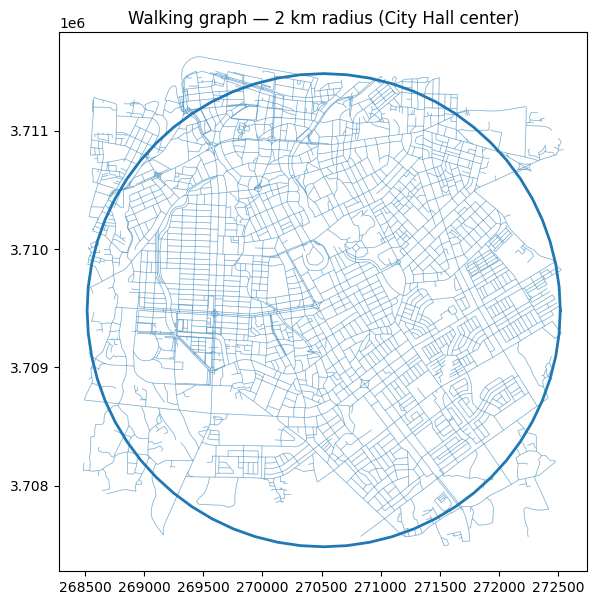

In [5]:

if GRAPHML_PATH and os.path.exists(GRAPHML_PATH):
    G = ox.load_graphml(GRAPHML_PATH)
else:
    G = ox.graph_from_point((CENTER_LAT, CENTER_LON), dist=RADIUS_M, network_type="walk", simplify=True)

Gp = project_graph(G)
nodes_proj, edges_proj = ox.graph_to_gdfs(Gp)
print(f"Nodes: {len(nodes_proj):,}, Edges: {len(edges_proj):,}")

center_geom = ox.projection.project_geometry(Point(CENTER_LON, CENTER_LAT), crs='EPSG:4326', to_crs=nodes_proj.crs)[0]

# Show 2 km circle
fig, ax = plt.subplots(figsize=(7,7))
edges_proj.plot(ax=ax, linewidth=0.5, alpha=0.35)
circle = center_geom.buffer(2000.0)
ax.plot(*circle.exterior.xy, lw=2)
ax.set_aspect('equal','box')
ax.set_title("Walking graph — 2 km radius (City Hall center)")
plt.show()


## 4) Build shape (built‑in **or** SVG) — PREVIEW ONLY

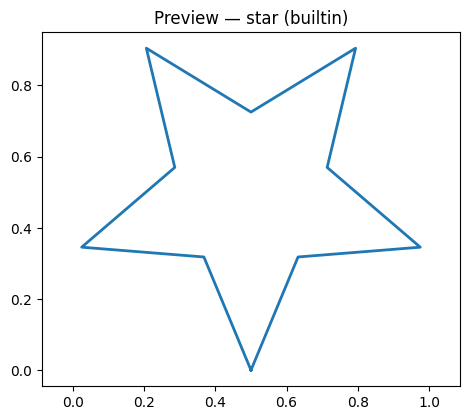

미리보기를 확인하세요. 마음에 들면 Config 셀에서 PROCEED=True 로 바꾼 뒤, 위에서부터 다시 실행하세요.


In [7]:

from shapely.geometry import LineString

# --- Built-in primitives ---
def star_polyline(n=5, inner_ratio=0.45, rot_deg=-90.0):
    pts = []
    step = np.pi / n
    rot = np.deg2rad(rot_deg)
    for k in range(2*n):
        r = 1.0 if k % 2 == 0 else inner_ratio
        a = rot + k*step
        x = 0.5 + 0.5*r*np.cos(a)
        y = 0.5 + 0.5*r*np.sin(a)
        pts.append((x,y))
    pts.append(pts[0])
    return LineString(pts)

def heart_polyline(samples=360):
    t = np.linspace(0, 2*np.pi, samples)
    x = 16*np.sin(t)**3
    y = 13*np.cos(t) - 5*np.cos(2*t) - 2*np.cos(3*t) - np.cos(4*t)
    coords = list(zip(x, y))
    coords = normalize_coords(coords, flip_y=False)
    return LineString(coords + [coords[0]])

def regular_polygon(n=6, rot_deg=-90.0):
    pts = []
    rot = np.deg2rad(rot_deg)
    for k in range(n):
        a = rot + 2*np.pi*k/n
        x = 0.5 + 0.5*np.cos(a)
        y = 0.5 + 0.5*np.sin(a)
        pts.append((x,y))
    pts.append(pts[0])
    return LineString(pts)

def spiral_polyline(turns=2.2, samples=420, rot_deg=-90.0):
    th = np.linspace(0.0, 2*np.pi*turns, samples)
    a, b = 0.03, 0.08/turns
    r = a + b*th
    x = r*np.cos(th); y = r*np.sin(th)
    coords = normalize_coords(list(zip(x, y)), flip_y=False)
    return LineString(coords)

def arrow_polyline(shaft_len=1.0, head_len=0.35, head_half=0.28, rot_deg=-90.0):
    x0 = 0.5
    base = (x0, 0.1)
    tip = (x0, 0.1 + shaft_len + head_len)
    left = (x0 - head_half, 0.1 + shaft_len)
    right = (x0 + head_half, 0.1 + shaft_len)
    coords = [base, (x0, 0.1 + shaft_len), tip, right, (x0, 0.1 + shaft_len), left, tip]
    coords = normalize_coords(coords, flip_y=False)
    return LineString(coords)

def dog_polyline(mode="simple", rot_deg=0.0):
    def bezier(p0, p1, p2, p3, n=40):
        t = np.linspace(0,1,n)
        return [((1-t0)**3*p0[0] + 3*(1-t0)**2*t0*p1[0] + 3*(1-t0)*t0**2*p2[0] + t0**3*p3[0],
                 (1-t0)**3*p0[1] + 3*(1-t0)**2*t0*p1[1] + 3*(1-t0)*t0**2*p2[1] + t0**3*p3[1]) for t0 in t]
    pts = []
    pts += bezier((0.05,0.55),(0.08,0.58),(0.11,0.60),(0.16,0.60), n=18)
    pts += bezier(pts[-1], (0.25,0.62), (0.32,0.64), (0.38,0.65), n=18)
    pts += bezier(pts[-1], (0.50,0.62), (0.56,0.64), (0.60,0.68), n=18)
    pts += bezier(pts[-1], (0.61,0.76), (0.64,0.76), (0.68,0.70), n=16)
    pts += bezier(pts[-1], (0.72,0.68), (0.78,0.66), (0.82,0.62), n=20)
    pts += bezier(pts[-1], (0.84,0.60), (0.78,0.58), (0.72,0.58), n=16)
    pts += bezier(pts[-1], (0.66,0.57), (0.62,0.56), (0.60,0.55), n=14)
    pts += bezier(pts[-1], (0.58,0.48), (0.58,0.42), (0.58,0.36), n=14)
    pts += bezier(pts[-1], (0.58,0.34), (0.56,0.40), (0.56,0.48), n=14)
    pts += bezier(pts[-1], (0.50,0.50), (0.46,0.49), (0.42,0.49), n=16)
    pts += bezier(pts[-1], (0.38,0.46), (0.36,0.40), (0.35,0.36), n=16)
    pts += bezier(pts[-1], (0.35,0.34), (0.33,0.44), (0.32,0.50), n=14)
    pts += bezier(pts[-1], (0.24,0.56), (0.20,0.58), (0.16,0.60), n=16)
    pts += bezier(pts[-1], (0.12,0.60), (0.08,0.58), (0.05,0.55), n=16)
    ls = LineString(pts + [pts[0]])
    # rotate around bounds center then normalize
    minx, miny, maxx, maxy = ls.bounds; cx, cy = (minx+maxx)/2, (miny+maxy)/2
    ls = shp_rotate(ls, rot_deg, origin=(cx, cy), use_radians=False)
    coords = normalize_coords(list(ls.coords), flip_y=False)
    return LineString(coords)

# --- SVG import ---
def svg_to_polyline(svg_path, path_index="auto", samples_per_seg=80, simplify=0.0, flip_y=True):
    from svgpathtools import svg2paths2
    paths, attrs, svg_att = svg2paths2(svg_path)
    # choose paths
    indices = range(len(paths)) if path_index == "auto" else [int(path_index)]
    line_parts = []
    for i in indices:
        p = paths[i]
        # sample each subpath uniformly per segment
        N = max(samples_per_seg * max(1, len(p)), samples_per_seg)
        t = np.linspace(0, 1, int(N))
        pts = [(complex(p.point(tt))).real for tt in t]  # wrong; we'll fix by extracting both x and y
        xys = [(p.point(tt).real, p.point(tt).imag) for tt in t]
        line_parts.append(LineString(xys))
    # optionally simplify each part
    if simplify and simplify > 0:
        line_parts = [ls.simplify(simplify, preserve_topology=True) for ls in line_parts]
    # reorder into single line with bridges
    merged = reorder_lines_min_bridges(line_parts)
    if merged is None:
        raise ValueError("No valid path extracted from SVG.")
    coords = normalize_coords(list(merged.coords), flip_y=flip_y)
    return LineString(coords)

# Build normalized shape
if MODE == "builtin":
    if SHAPE == "star":
        shape_norm = star_polyline(n=STAR_POINTS, inner_ratio=STAR_INNER_RATIO, rot_deg=STAR_ROT_DEG)
    elif SHAPE == "heart":
        shape_norm = heart_polyline(samples=360)
    elif SHAPE == "triangle":
        shape_norm = regular_polygon(n=3, rot_deg=POLY_ROT_DEG)
    elif SHAPE == "polygon":
        shape_norm = regular_polygon(n=POLY_SIDES, rot_deg=POLY_ROT_DEG)
    elif SHAPE == "spiral":
        shape_norm = spiral_polyline(turns=SPIRAL_TURNS, samples=SPIRAL_SAMPLES, rot_deg=SPIRAL_ROT_DEG)
    elif SHAPE == "arrow":
        shape_norm = arrow_polyline(shaft_len=ARROW_SHAFT_LEN, head_len=ARROW_HEAD_LEN, head_half=ARROW_HEAD_HALF, rot_deg=ARROW_ROT_DEG)
    elif SHAPE == "dog":
        shape_norm = dog_polyline(mode=DOG_MODE, rot_deg=DOG_ROT_DEG)
    else:
        raise ValueError("Unknown SHAPE")
elif MODE == "svg":
    shape_norm = svg_to_polyline(SVG_FILE, path_index=SVG_PATH_INDEX, samples_per_seg=SVG_SAMPLES_PER_SEG,
                                 simplify=SVG_SIMPLIFY, flip_y=SVG_FLIP_Y)
else:
    raise ValueError("MODE must be 'builtin' or 'svg'")

# PREVIEW
xv, yv = zip(*list(shape_norm.coords))
plt.figure(figsize=(5.4,4.6))
plt.plot(xv, yv, linewidth=2)
plt.axis("equal")
ttl = f"Preview — {SHAPE} (builtin)" if MODE=="builtin" else f"Preview — SVG: {SVG_FILE}"
plt.title(ttl)
plt.show()
print("미리보기를 확인하세요. 마음에 들면 Config 셀에서 PROCEED=True 로 바꾼 뒤, 위에서부터 다시 실행하세요.")


## 5) Proceed gate (stop here until PREVIEW is OK)

In [193]:

assert PROCEED, "미리보기가 만족스러우면 PROCEED=True로 설정하고 위에서부터 다시 실행하세요."


## 6) Map to inner canvas & rotate

In [9]:

minx, miny, maxx, maxy = graph_bounds(nodes_proj)
W, H = maxx - minx, maxy - miny
cx, cy = minx + W/2, miny + H/2

# Inner canvas bbox
w_i, h_i = W*CANVAS_BOX_FRAC, H*CANVAS_BOX_FRAC
minx_i, miny_i = cx - w_i/2, cy - h_i/2
maxx_i, maxy_i = cx + w_i/2, cy + h_i/2

mapped = LineString([ (minx_i + px*w_i, miny_i + py*h_i) for (px,py) in shape_norm.coords ])
mapped = shp_rotate(mapped, GLOBAL_ROT_DEG, origin=(cx, cy), use_radians=False)


## 7) Snap to graph (start & return), with waypoint thinning

In [11]:

node_xy = np.column_stack([nodes_proj.geometry.x.values, nodes_proj.geometry.y.values])
node_ids = nodes_proj.index.values

def nearest_node_id(x, y):
    d2 = (node_xy[:,0]-x)**2 + (node_xy[:,1]-y)**2
    return node_ids[d2.argmin()]

def route_via_shape(line: LineString, step=SAMPLE_STEP_M, min_gap=MIN_WP_GAP_M, return_to_start=True):
    # 1) Densify + thin
    wps = densify_line(line, step=step)
    wps = thin_points(wps, min_gap=min_gap)

    # 2) Start/finish at City Hall
    center_proj = ox.projection.project_geometry(Point(CENTER_LON, CENTER_LAT), crs='EPSG:4326', to_crs=nodes_proj.crs)[0]
    if return_to_start:
        wps = [center_proj] + wps + [center_proj]
    else:
        wps = [center_proj] + wps

    # 3) Snap & connect
    snaps = []
    for p in wps:
        x, y = (p.x, p.y) if hasattr(p, "x") else p.coords[0]
        nid = nearest_node_id(x, y)
        if not snaps or snaps[-1] != nid:
            snaps.append(nid)

    rnodes = []
    for a, b in zip(snaps[:-1], snaps[1:]):
        try:
            sp = nx.shortest_path(Gp, a, b, weight='length')
            if rnodes and rnodes[-1]==sp[0]:
                rnodes.extend(sp[1:])
            else:
                rnodes.extend(sp)
        except nx.NetworkXNoPath:
            continue

    if not rnodes:
        return None, None

    coords = nodes_proj.loc[rnodes].geometry.apply(lambda g:(g.x,g.y)).tolist()
    rline = LineString(coords)
    return rnodes, rline


## 8) Auto-scale search to hit ~8 km (±5%)

In [13]:

target_min = TARGET_KM*(1-TOLERANCE)
target_max = TARGET_KM*(1+TOLERANCE)

best = None
lo, hi = 0.10, 0.95
for _ in range(14):
    mid = 0.5*(lo+hi)
    tuned = shp_scale(mapped, xfact=mid, yfact=mid, origin=(cx, cy))
    rn, rl = route_via_shape(tuned, step=SAMPLE_STEP_M, min_gap=MIN_WP_GAP_M, return_to_start=RETURN_TO_START)
    if rl is None:
        lo = mid
        continue
    Lkm = rl.length/1000.0
    if target_min <= Lkm <= target_max:
        best = (mid, rn, rl, Lkm)
        break
    if Lkm < target_min:
        lo = mid
    else:
        hi = mid
    if best is None or abs(Lkm - TARGET_KM) < abs(best[3] - TARGET_KM):
        best = (mid, rn, rl, Lkm)

scale_used, route_nodes, route_line, Lkm = best
print(f"Scale {scale_used:.3f} → length {Lkm:.3f} km (target {TARGET_KM}±{int(TOLERANCE*100)}%)")


Scale 0.738 → length 7.983 km (target 8.0±5%)


## 9) Elevation — robust fallback

Elevation loaded via SRTM.
Elevation gain: 1684.0 m, loss: 1684.0 m (NaN means elevation unavailable)


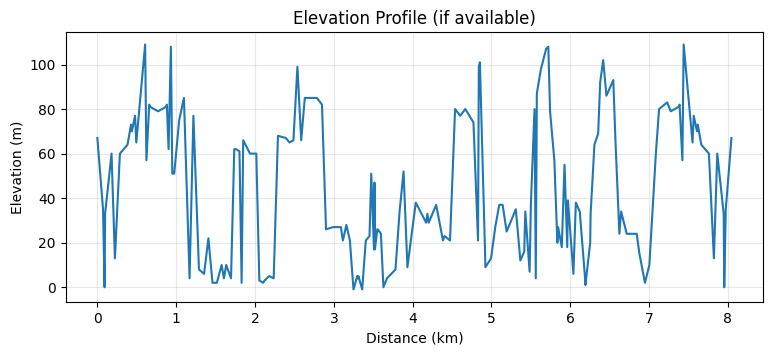

In [15]:

def add_elevation_to_graph(Gproj):
    try:
        if USE_DEM_RASTER and os.path.exists(DEM_RASTER_PATH):
            import rasterio
            return ox.elevation.add_node_elevations_raster(Gproj, DEM_RASTER_PATH, max_locations_per_batch=50)
        else:
            try:
                import srtm
                G_ll = ox.project_graph(Gproj, to_crs='EPSG:4326')
                nodes_ll, _ = ox.graph_to_gdfs(G_ll)
                provider = srtm.get_data()
                elev = [provider.get_elevation(lat, lon) or 0.0
                        for lat, lon in zip(nodes_ll['y'].values, nodes_ll['x'].values)]
                nodes_p, _ = ox.graph_to_gdfs(Gproj)
                for nid, h in zip(nodes_p.index.values, elev):
                    Gproj.nodes[nid]['elevation'] = float(h)
                print("Elevation loaded via SRTM.")
                return Gproj
            except Exception as e2:
                print("SRTM fallback failed — continuing without elevation.", e2)
                return Gproj
    except Exception as e:
        print("Elevation (DEM) failed — continuing without elevation.", e)
        return Gproj

Gp = add_elevation_to_graph(Gp)

# Distance & elevation arrays
dist = [0.0]; elev = []; prev = None
for nid in route_nodes:
    elev.append(Gp.nodes[nid].get('elevation', np.nan))
    if prev is None:
        prev = nid; continue
    try:
        d = Gp[prev][nid][0].get('length', None)
    except Exception:
        d = None
    if d is None:
        a = nodes_proj.loc[prev].geometry; b = nodes_proj.loc[nid].geometry
        d = ((a.x-b.x)**2 + (a.y-b.y)**2)**0.5
    dist.append(dist[-1]+d); prev = nid

dist_km = np.array(dist)/1000.0; elev_arr = np.array(elev, dtype=float)
gain = float(np.nansum(np.clip(np.diff(elev_arr), 0, None)))
loss = float(np.nansum(np.clip(np.diff(elev_arr), None, 0)))
print(f"Elevation gain: {gain:.1f} m, loss: {abs(loss):.1f} m (NaN means elevation unavailable)")

plt.figure(figsize=(9,3.5))
plt.plot(dist_km, elev_arr, linewidth=1.5)
plt.xlabel("Distance (km)"); plt.ylabel("Elevation (m)")
plt.title("Elevation Profile (if available)"); plt.grid(True, alpha=0.3); plt.show()


## 10) Map & Summary

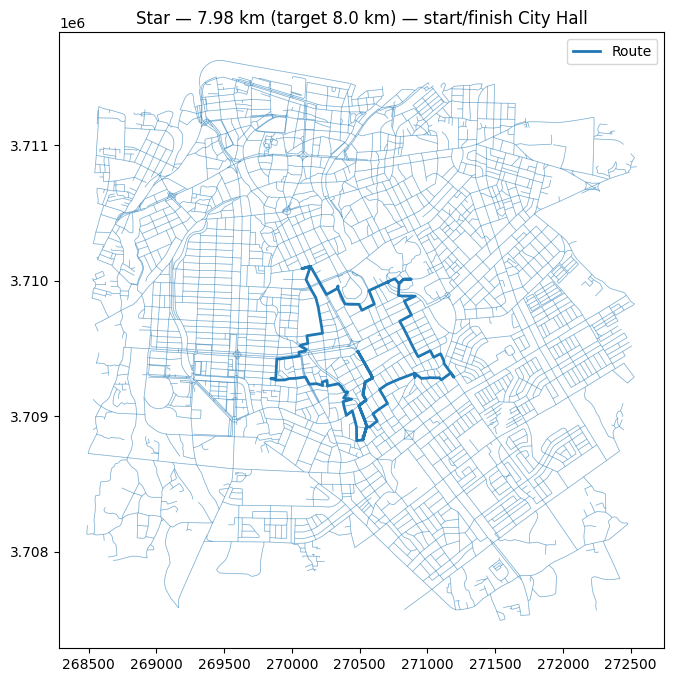

,Mode,Shape,Target (km),Actual (km),Tolerance (%),Scale used,Canvas frac,Radius (m),Return to start,Elevation gain (m),Elevation loss (m)
0,builtin,star,8.0,7.983,5,0.738,0.48,2000,True,1684.0,1684.0


In [17]:

plot_map_with_route(edges_proj, route_line,
                    title=f"{'SVG' if MODE=='svg' else SHAPE.capitalize()} — {Lkm:.2f} km (target {TARGET_KM} km) — start/finish City Hall")

summary = {
    "Mode": MODE,
    "Shape": SHAPE if MODE=='builtin' else "SVG",
    "Target (km)": TARGET_KM,
    "Actual (km)": round(Lkm, 3),
    "Tolerance (%)": int(TOLERANCE*100),
    "Scale used": round(scale_used, 3),
    "Canvas frac": CANVAS_BOX_FRAC,
    "Radius (m)": RADIUS_M,
    "Return to start": RETURN_TO_START,
    "Elevation gain (m)": round(gain, 1),
    "Elevation loss (m)": round(abs(loss), 1),
}
import pandas as pd
pd.DataFrame([summary])
